In [149]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [150]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [151]:
len(words)

32033

In [152]:
chars = [chr(i) for i in range(97, 97 + 26)]
stoi = {s: i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [153]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [154]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [155]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [156]:
sum(p.nelement() for p in parameters) # number of parameters in total

10281

In [157]:
for p in parameters:
    p.requires_grad = True

In [170]:
lossi = []
stepi = []

for i in range(30000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.01
    # update
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.item())

2.1811649799346924
2.440443754196167
2.492156505584717
2.3425991535186768
2.298557996749878
2.9132652282714844
2.223001003265381
2.4010367393493652
2.07169771194458
2.025993585586548
2.1743905544281006
2.1972343921661377
2.469621419906616
2.5828371047973633
2.1336283683776855
2.236769914627075
2.3532862663269043
2.116912364959717
2.3884775638580322
2.384544849395752
2.641749620437622
1.8531420230865479
1.9881341457366943
2.4260754585266113
2.4301609992980957
2.0116946697235107
2.6952531337738037
2.2013165950775146
1.8183884620666504
2.300415277481079
2.4362096786499023
2.146270275115967
2.4780213832855225
2.5558338165283203
1.9358088970184326
2.4807987213134766
2.430634021759033
2.3696022033691406
2.279350519180298
2.3503212928771973
2.2460901737213135
2.1946027278900146
2.0852227210998535
2.576014995574951
2.593309164047241
2.0879807472229004
2.2594306468963623
2.0718820095062256
2.512688398361206
2.068570613861084
2.256755828857422
2.1378746032714844
2.002635955810547
2.7541120052337

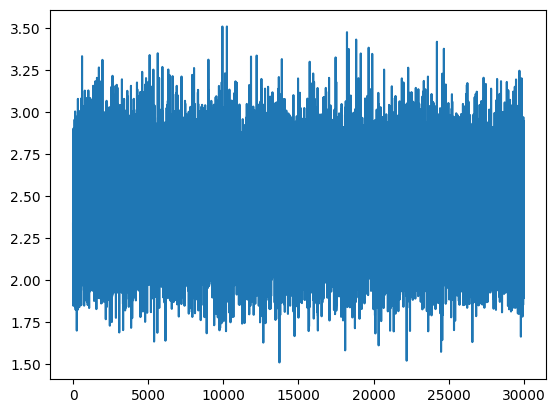

In [167]:
plt.plot(stepi, lossi)

In [171]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2317, grad_fn=<NllLossBackward0>)

In [172]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2446, grad_fn=<NllLossBackward0>)

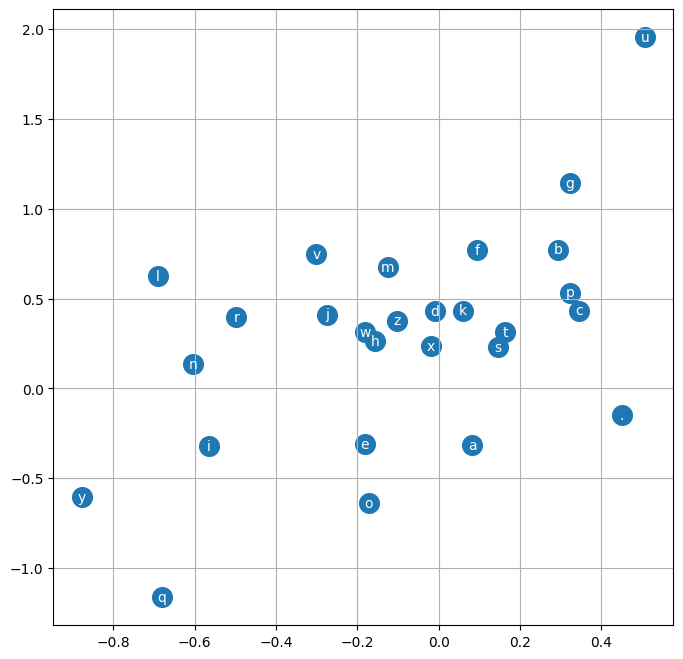

In [173]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# you can see that a, e, i, o are clustered together, it means our model is learning that these characters are used in similar context

In [ ]:
# we increased the number of parameters of middle layer
# but we could improve the model performance much
# currently we are using 2 numbers to represent a character
# next we would use more (represent them in bigger dimensional space)